# Unsupervised Domain Adaptation 

In [1]:
import os, time, random, json
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset,TensorDataset, DataLoader, ConcatDataset,Dataset
from torch.autograd import Function
from scipy.stats import entropy
from copy import deepcopy


from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

In [26]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
num_classes = 7
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0

### Data preperation and loading

In [31]:
SOURCE_DOMAIN = "photo"
TARGET_DOMAIN = "sketch" 

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

source_data = datasets.ImageFolder(root="/kaggle/input/d/quandnguyen/pacs-dataset/my/datasets/path/PACS/photo", transform=data_transforms)
target_data = datasets.ImageFolder(root='/kaggle/input/d/quandnguyen/pacs-dataset/my/datasets/path/PACS/sketch', transform=data_transforms)

source_labels = [label for _, label in source_data.samples]
train_indices, val_indices = train_test_split(
    list(range(len(source_data))), test_size=0.2, stratify=source_labels, random_state=SEED)

source_train = Subset(source_data, train_indices)
source_val = Subset(source_data, val_indices)


source_train_loader = DataLoader(source_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                                 num_workers=NUM_WORKERS, pin_memory=True)
source_val_loader = DataLoader(source_val, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)
target_loader = DataLoader(target_data, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=True)

print(f"Source total: {len(source_data)}, train: {len(source_train)}, val: {len(source_val)}")
print(f"Target total: {len(target_data)}")

Source total: 1670, train: 1336, val: 334
Target total: 3929


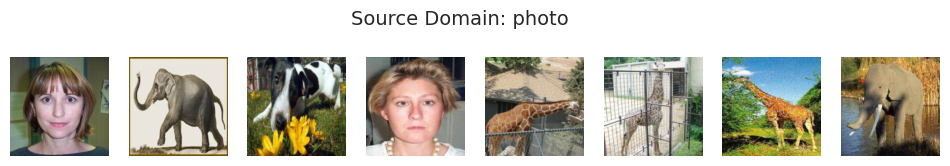

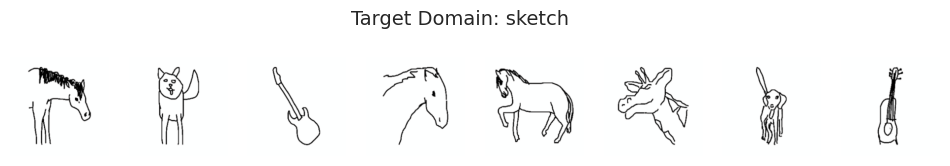

In [5]:
def imshow_batch(dataset, title, n=8):
    plt.figure(figsize=(12, 2))
    indices = random.sample(range(len(dataset)), n)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip((img * np.array([0.229, 0.224, 0.225]) + 
                       np.array([0.485, 0.456, 0.406])), 0, 1)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

# Show samples
imshow_batch(source_data, f"Source Domain: {SOURCE_DOMAIN}")
imshow_batch(target_data, f"Target Domain: {TARGET_DOMAIN}")

### Base model

In [6]:
class ResNet50WithFeatures(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        res = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = nn.Sequential(*list(res.children())[:-1])
        feat_dim = res.fc.in_features
        self.bottleneck = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x, return_feat=False):
        f = torch.flatten(self.features(x), 1)
        b = self.bottleneck(f)
        out = self.classifier(b)
        return (out, b) if return_feat else out

In [14]:
baseline_model = ResNet50WithFeatures(num_classes=num_classes, pretrained=False)
state_dict = torch.load("/kaggle/working/baseline_ResNet50.pth", map_location=DEVICE)
baseline_model.load_state_dict(state_dict)
baseline_model.to(DEVICE)
baseline_model.eval()

with open("/kaggle/working/dan_history.json", "r") as f:
    hist_baseline = json.load(f)

##  Source-Only Baseline

In [15]:

def compute_acc(model, loader):
    model.eval()
    total, correct = 0, 0
    all_y, all_p = [], []
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=1)
            total += y.size(0)
            correct += (preds==y).sum().item()
            all_y.append(y.cpu().numpy()); all_p.append(preds.cpu().numpy())
    if total==0:
        return 0.0, np.array([]), np.array([])
    return correct/total, np.concatenate(all_y), np.concatenate(all_p)

def evaluate(loader, model):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(DEVICE), labs.to(DEVICE)
            logits = model(imgs)
            _, preds = torch.max(logits, 1)
            correct += (preds == labs).sum().item()
            total += labs.size(0)
    return correct / total

In [18]:
def train_baseline_model(num_classes, source_train_loader, source_val_loader, target_loader,
                         device,
                         epochs=20,
                         lr_backbone=1e-4,
                         lr_classifier=1e-3,
                         weight_decay=1e-4,
                         save_path="baseline_best.pth"):
    
    model = ResNet50WithFeatures(num_classes=num_classes, pretrained=True)
    in_features = model.classifier.in_features  
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    backbone_params = [p for name, p in model.named_parameters() if "classifier" not in name]
    classifier_params = [p for name, p in model.named_parameters() if "classifier" in name]
    optimizer = optim.SGD([
        {"params": backbone_params, "lr": lr_backbone},
        {"params": classifier_params, "lr": lr_classifier}
    ], momentum=0.9, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    hist_baseline = {
        "loss": [],
        "src_acc": [],
        "tgt_acc": []
    }

    best_val_acc = 0.0

    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0

        for xb, yb in source_train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)  
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)

        epoch_loss = running_loss / total_samples
        hist_baseline["loss"].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            correct_src = 0
            total_src = 0
            for xb, yb in source_val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                correct_src += (preds == yb).sum().item()
                total_src += yb.size(0)
            src_acc = correct_src / total_src
        hist_baseline["src_acc"].append(src_acc * 100.0)

        with torch.no_grad():
            correct_tgt = 0
            total_tgt = 0
            for xb, yb in target_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                correct_tgt += (preds == yb).sum().item()
                total_tgt += yb.size(0)
            if total_tgt > 0:
                tgt_acc = correct_tgt / total_tgt
            else:
                tgt_acc = 0.0
        hist_baseline["tgt_acc"].append(tgt_acc * 100.0)

        print(f"[Epoch {ep+1}/{epochs}] Loss: {epoch_loss:.4f} | Src Val Acc: {src_acc:.4f} | Tgt Acc: {tgt_acc:.4f}")

        if src_acc > best_val_acc:
            best_val_acc = src_acc
            torch.save(model.state_dict(), save_path)

        scheduler.step()

    model.load_state_dict(torch.load(save_path))
    return model, hist_baseline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model, hist_baseline = train_baseline_model(
    num_classes=num_classes,
    source_train_loader=source_train_loader,
    source_val_loader=source_val_loader,
    target_loader=target_loader,
    device=device,
    epochs=20,
    lr_backbone=1e-4,
    lr_classifier=1e-3,
    weight_decay=1e-4,
    save_path="/kaggle/working/baseline_ResNet50.pth"
)

with open("/kaggle/working/baseline_history.json", "w") as f:
    json.dump(hist_baseline, f, indent=2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s] 


[Epoch 1/20] Loss: 1.4055 | Src Val Acc: 0.9401 | Tgt Acc: 0.2489
[Epoch 2/20] Loss: 0.5513 | Src Val Acc: 0.9760 | Tgt Acc: 0.3482
[Epoch 3/20] Loss: 0.3304 | Src Val Acc: 0.9790 | Tgt Acc: 0.3446
[Epoch 4/20] Loss: 0.2251 | Src Val Acc: 0.9850 | Tgt Acc: 0.3874
[Epoch 5/20] Loss: 0.1769 | Src Val Acc: 0.9850 | Tgt Acc: 0.3747
[Epoch 6/20] Loss: 0.1461 | Src Val Acc: 0.9880 | Tgt Acc: 0.3968
[Epoch 7/20] Loss: 0.1137 | Src Val Acc: 0.9880 | Tgt Acc: 0.3823
[Epoch 8/20] Loss: 0.1101 | Src Val Acc: 0.9880 | Tgt Acc: 0.3797
[Epoch 9/20] Loss: 0.0958 | Src Val Acc: 0.9910 | Tgt Acc: 0.3981
[Epoch 10/20] Loss: 0.0751 | Src Val Acc: 0.9850 | Tgt Acc: 0.3881
[Epoch 11/20] Loss: 0.0776 | Src Val Acc: 0.9850 | Tgt Acc: 0.3825
[Epoch 12/20] Loss: 0.0831 | Src Val Acc: 0.9910 | Tgt Acc: 0.3894
[Epoch 13/20] Loss: 0.0682 | Src Val Acc: 0.9940 | Tgt Acc: 0.3856
[Epoch 14/20] Loss: 0.0696 | Src Val Acc: 0.9850 | Tgt Acc: 0.3642
[Epoch 15/20] Loss: 0.0618 | Src Val Acc: 0.9850 | Tgt Acc: 0.3808
[Epo

In [89]:
model_baseline = ResNet50WithFeatures(num_classes=num_classes, pretrained=False).to(DEVICE)
model_baseline.load_state_dict(torch.load("/kaggle/working/baseline_ResNet50.pth", map_location=DEVICE))

with open("/kaggle/working/baseline_history.json", "r") as f:
    baseline_hist = json.load(f)

In [16]:
#visualizations
# ICML style

plt.style.use('default')
matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",   # safe default
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})


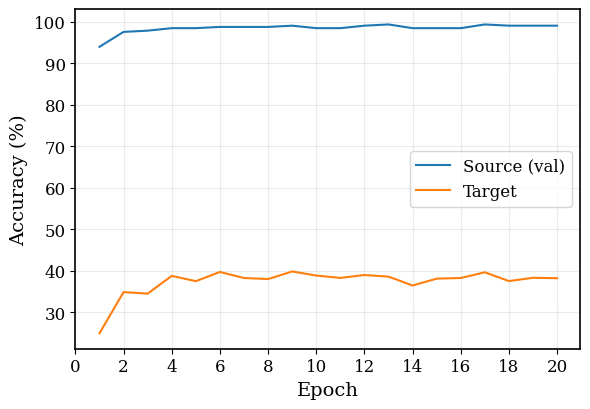

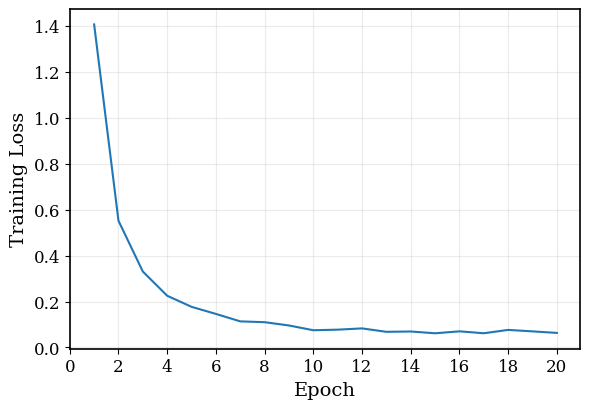

In [13]:

epochs = np.arange(1, len(hist_baseline["src_acc"]) + 1)
fig, ax = plt.subplots(figsize=(6, 4.2))
ax.plot(epochs, hist_baseline["src_acc"], label="Source (val)")
ax.plot(epochs, hist_baseline["tgt_acc"], label="Target")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_xticks([0, 2, 4, 6, 8, 10,12,14,16,18,20])
ax.legend()
plt.grid(True, alpha =0.25)
plt.tight_layout()
fig.savefig("baseline_acc.png", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(6, 4.2))
ax.plot(epochs, hist_baseline["loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_xticks([0, 2, 4, 6, 8, 10,12,14,16,18,20])
plt.grid(True, alpha =0.25)
plt.tight_layout()
plt.savefig("baseline_loss.png", bbox_inches="tight")
plt.show()

## Domain Alignment Methods

**Some utility functions**

In [17]:
def compute_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return 1.0 * correct / total if total > 0 else 0


# MMD 
def gaussian_kernel(x, y, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(x.size(0)) + int(y.size(0))
    total = torch.cat([x, y], dim=0)
    total0 = total.unsqueeze(0).expand(total.size(0), total.size(0), total.size(1))
    total1 = total.unsqueeze(1).expand(total.size(0), total.size(0), total.size(1))
    L2_distance = ((total0 - total1) ** 2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples ** 2 - n_samples)
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)

def mmd_loss_np(X, Y):
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    return mmd_loss_torch(X, Y).item()

def mmd_loss_torch(source, target):
    kernels = gaussian_kernel(source, target)
    batch_size = source.size(0)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    return torch.mean(XX + YY - XY - YX)


### Deep Alignment Network(DAN)

In [39]:
def train_dan(model, src_loader, tgt_loader, src_val_loader, epochs=25, mmd_weight=0.5, lr_feat=1e-4, lr_cls=1e-3):
    model = model.to(DEVICE)
    optimizer = torch.optim.SGD([{'params': model.features.parameters(), 'lr': lr_feat},
                                 {'params': model.classifier.parameters(), 'lr': lr_cls}],
                                momentum=0.9, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    hist = {'loss':[], 'src_acc':[], 'tgt_acc':[]}
    for ep in range(epochs):
        model.train()
        total_loss=0.0
        steps = min(len(src_loader), len(tgt_loader))
        src_iter = iter(src_loader); tgt_iter = iter(tgt_loader)
        for _ in range(steps):
            xb_s, yb_s = next(src_iter); xb_t, _ = next(tgt_iter)
            xb_s, yb_s, xb_t = xb_s.to(DEVICE), yb_s.to(DEVICE), xb_t.to(DEVICE)
            logits_s, feat_s = model(xb_s, return_feat=True)
            _, feat_t = model(xb_t, return_feat=True)
            cls_loss = crit(logits_s, yb_s)
            mmd = mmd_loss_torch(feat_s, feat_t)
            loss = cls_loss + mmd_weight * mmd
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()
        src_acc = compute_accuracy(model, src_val_loader)
        tgt_acc = compute_accuracy(model, tgt_loader)
        hist['loss'].append(total_loss/steps); hist['src_acc'].append(100*src_acc); hist['tgt_acc'].append(100*tgt_acc)
        print(f"[DAN] Ep {ep+1}/{epochs} Loss {total_loss/steps:.4f} SrcVal {src_acc:.4f} Tgt {tgt_acc:.4f}")
    return model, hist


dan_model = ResNet50WithFeatures(num_classes=num_classes, pretrained=True).to(DEVICE)
dan_model, hist_dan = train_dan(dan_model, source_train_loader, target_loader, source_val_loader, epochs=25, mmd_weight=0.5)

torch.save(dan_model.state_dict(), "/kaggle/working/resnet50_dan.pth")

with open("/kaggle/working/dan_history.json", "w") as f:
    json.dump(hist_dan, f, indent=2)


[DAN] Ep 1/25 Loss 1.5879 SrcVal 0.6557 Tgt 0.0962
[DAN] Ep 2/25 Loss 0.8709 SrcVal 0.8653 Tgt 0.2828
[DAN] Ep 3/25 Loss 0.5555 SrcVal 0.9192 Tgt 0.3344
[DAN] Ep 4/25 Loss 0.4174 SrcVal 0.9371 Tgt 0.3586
[DAN] Ep 5/25 Loss 0.3249 SrcVal 0.9491 Tgt 0.3752
[DAN] Ep 6/25 Loss 0.2835 SrcVal 0.9491 Tgt 0.3843
[DAN] Ep 7/25 Loss 0.2245 SrcVal 0.9551 Tgt 0.3942
[DAN] Ep 8/25 Loss 0.2017 SrcVal 0.9521 Tgt 0.3894
[DAN] Ep 9/25 Loss 0.1938 SrcVal 0.9551 Tgt 0.3866
[DAN] Ep 10/25 Loss 0.1636 SrcVal 0.9551 Tgt 0.4047
[DAN] Ep 11/25 Loss 0.1521 SrcVal 0.9581 Tgt 0.4149
[DAN] Ep 12/25 Loss 0.1420 SrcVal 0.9701 Tgt 0.4164
[DAN] Ep 13/25 Loss 0.1224 SrcVal 0.9701 Tgt 0.3981
[DAN] Ep 14/25 Loss 0.1260 SrcVal 0.9731 Tgt 0.3965
[DAN] Ep 15/25 Loss 0.1116 SrcVal 0.9671 Tgt 0.4110
[DAN] Ep 16/25 Loss 0.1054 SrcVal 0.9701 Tgt 0.3983
[DAN] Ep 17/25 Loss 0.1009 SrcVal 0.9701 Tgt 0.4166
[DAN] Ep 18/25 Loss 0.0903 SrcVal 0.9731 Tgt 0.3920
[DAN] Ep 19/25 Loss 0.0900 SrcVal 0.9731 Tgt 0.4029
[DAN] Ep 20/25 Loss 0

## DANN (DomainAdversarial Neural Network)

In [18]:
class GRL(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha; return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradReverseLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__(); self.alpha = alpha
    def forward(self, x):
        return GRL.apply(x, self.alpha)

class DomainDiscriminator(nn.Module):
    def __init__(self, in_dim=2048, hidden=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden//2, 2)
        )
    def forward(self, x): return self.net(x)

In [44]:
def train_dann(model, src_loader, tgt_loader, src_val_loader, epochs=25, adv_weight=0.1, lrF=1e-4, lrD=1e-3):
    model = model.to(DEVICE)
    disc = DomainDiscriminator(in_dim=256, hidden=1024).to(DEVICE)
    optF = torch.optim.SGD(list(model.features.parameters()) + list(model.classifier.parameters()), lr=lrF, momentum=0.9, weight_decay=1e-4)
    optD = torch.optim.SGD(disc.parameters(), lr=lrD, momentum=0.9, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    hist = {'loss':[], 'src_acc':[], 'tgt_acc':[]}
    grl = GradReverseLayer()
    for ep in range(epochs):
        model.train(); disc.train()
        src_iter = iter(src_loader); tgt_iter = iter(tgt_loader)
        steps = min(len(src_loader), len(tgt_loader))
        tot_loss = 0.0
        for step in range(steps):
            xb_s, yb_s = next(src_iter); xb_t, _ = next(tgt_iter)
            xb_s, yb_s, xb_t = xb_s.to(DEVICE), yb_s.to(DEVICE), xb_t.to(DEVICE)
            # features
            _, feat_s = model(xb_s, return_feat=True)
            _, feat_t = model(xb_t, return_feat=True)
            # discriminator 
            d_in = torch.cat([feat_s.detach(), feat_t.detach()], dim=0)
            d_labels = torch.cat([torch.zeros(feat_s.size(0), dtype=torch.long), torch.ones(feat_t.size(0), dtype=torch.long)], dim=0).to(DEVICE)
            d_logits = disc(d_in)
            d_loss = crit(d_logits, d_labels)
            optD.zero_grad(); d_loss.backward(); optD.step()
           
            # classification loss
            logits_s = model.classifier(feat_s)
            cls_loss = crit(logits_s, yb_s)
            # adversarial loss
            d_in_adv = torch.cat([feat_s, feat_t], dim=0)
            #  GRL
            reversed_feat = grl(d_in_adv)
            adv_logits = disc(reversed_feat)
            adv_labels = d_labels
            adv_loss = crit(adv_logits, adv_labels)
            loss = cls_loss + adv_weight * adv_loss
            optF.zero_grad(); loss.backward(); optF.step()
            tot_loss += loss.item()
        src_acc = compute_accuracy(model, src_val_loader)
        tgt_acc = compute_accuracy(model, tgt_loader)
        hist['loss'].append(tot_loss/steps); hist['src_acc'].append(100*src_acc); hist['tgt_acc'].append(100*tgt_acc)
        print(f"[DANN] Ep {ep+1}/{epochs} Loss {tot_loss/steps:.4f} SrcVal {src_acc:.4f} Tgt {tgt_acc:.4f}")
    return model, disc, hist

dann_model = ResNet50WithFeatures(num_classes=num_classes, pretrained=True).to(DEVICE)
dann_model, dann_disc, hist_dann = train_dann(dann_model, source_train_loader, target_loader, source_val_loader, epochs=25, adv_weight=0.1)



torch.save(dann_model.state_dict(), "/kaggle/working/resnet50_dann.pth")
with open("/kaggle/working/dann_history.json", "w") as f:
    json.dump(hist_dann, f, indent=2)



[DANN] Ep 1/25 Loss 1.9929 SrcVal 0.4132 Tgt 0.1507
[DANN] Ep 2/25 Loss 1.5344 SrcVal 0.6766 Tgt 0.1883
[DANN] Ep 3/25 Loss 1.1939 SrcVal 0.7455 Tgt 0.2176
[DANN] Ep 4/25 Loss 0.9726 SrcVal 0.8234 Tgt 0.2843
[DANN] Ep 5/25 Loss 0.8177 SrcVal 0.8413 Tgt 0.3329
[DANN] Ep 6/25 Loss 0.6966 SrcVal 0.8772 Tgt 0.3698
[DANN] Ep 7/25 Loss 0.6022 SrcVal 0.9042 Tgt 0.3747
[DANN] Ep 8/25 Loss 0.5414 SrcVal 0.9222 Tgt 0.3991
[DANN] Ep 9/25 Loss 0.4755 SrcVal 0.9341 Tgt 0.4141
[DANN] Ep 10/25 Loss 0.4396 SrcVal 0.9281 Tgt 0.4110
[DANN] Ep 11/25 Loss 0.4113 SrcVal 0.9431 Tgt 0.4408
[DANN] Ep 12/25 Loss 0.3764 SrcVal 0.9521 Tgt 0.4449
[DANN] Ep 13/25 Loss 0.3318 SrcVal 0.9581 Tgt 0.4355
[DANN] Ep 14/25 Loss 0.3201 SrcVal 0.9551 Tgt 0.4548
[DANN] Ep 15/25 Loss 0.3033 SrcVal 0.9581 Tgt 0.4576
[DANN] Ep 16/25 Loss 0.2840 SrcVal 0.9581 Tgt 0.4574
[DANN] Ep 17/25 Loss 0.2620 SrcVal 0.9611 Tgt 0.4645
[DANN] Ep 18/25 Loss 0.2493 SrcVal 0.9521 Tgt 0.4686
[DANN] Ep 19/25 Loss 0.2460 SrcVal 0.9671 Tgt 0.4843
[D

### CDAN

In [19]:
class CDANDomainDiscriminator(nn.Module):
    def __init__(self, in_dim, hidden=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden//2, 2)
        )
    def forward(self, x): return self.net(x)

In [14]:
def train_cdan(model, src_loader, tgt_loader, src_val_loader, epochs=25, adv_weight=0.1, lrF=1e-4, lrD=1e-3):
    model = model.to(DEVICE)
    disc = CDANDomainDiscriminator(in_dim=256 + num_classes, hidden=512).to(DEVICE)  
    optF = torch.optim.SGD(list(model.features.parameters()) + list(model.classifier.parameters()), lr=lrF, momentum=0.9, weight_decay=1e-4)
    optD = torch.optim.SGD(disc.parameters(), lr=lrD, momentum=0.9, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)
    grl = GradReverseLayer()
    hist = {'loss':[], 'src_acc':[], 'tgt_acc':[]}
    for ep in range(epochs):
        model.train(); disc.train()
        src_iter = iter(src_loader); tgt_iter = iter(tgt_loader)
        steps = min(len(src_loader), len(tgt_loader))
        tot_loss = 0.0
        for _ in range(steps):
            xb_s, yb_s = next(src_iter); xb_t, _ = next(tgt_iter)
            xb_s, yb_s, xb_t = xb_s.to(DEVICE), yb_s.to(DEVICE), xb_t.to(DEVICE)
            logits_s, feat_s = model(xb_s, return_feat=True)
            logits_t, feat_t = model(xb_t, return_feat=True)
            probs_s = softmax(logits_s); probs_t = softmax(logits_t)
            cond_s = torch.cat([feat_s, probs_s], dim=1)
            cond_t = torch.cat([feat_t, probs_t], dim=1)
            # training disc
            d_in = torch.cat([cond_s.detach(), cond_t.detach()], dim=0)
            d_labels = torch.cat([torch.zeros(cond_s.size(0), dtype=torch.long), torch.ones(cond_t.size(0), dtype=torch.long)], dim=0).to(DEVICE)
            d_logits = disc(d_in)
            d_loss = crit(d_logits, d_labels)
            optD.zero_grad(); d_loss.backward(); optD.step()
            d_in_adv = torch.cat([cond_s, cond_t], dim=0)
            reversed_in = grl(d_in_adv)
            adv_logits = disc(reversed_in)
            adv_loss = crit(adv_logits, d_labels)
            cls_loss = crit(logits_s, yb_s)
            loss = cls_loss + adv_weight * adv_loss
            optF.zero_grad(); loss.backward(); optF.step()
            tot_loss += loss.item()
        src_acc = compute_accuracy(model, src_val_loader)
        tgt_acc = compute_accuracy(model, tgt_loader)
        hist['loss'].append(tot_loss/steps); hist['src_acc'].append(100*src_acc); hist['tgt_acc'].append(100*tgt_acc)
        print(f"[CDAN] Ep {ep+1}/{epochs} Loss {tot_loss/steps:.4f} SrcVal {src_acc:.4f} Tgt {tgt_acc:.4f}")
    return model, disc, hist

cdan_model = ResNet50WithFeatures(num_classes=num_classes, pretrained=True).to(DEVICE)
cdan_model, cdan_disc, hist_cdan = train_cdan(cdan_model, source_train_loader, target_loader, source_val_loader, epochs=25, adv_weight=0.1)

torch.save(cdan_model.state_dict(), "/kaggle/working/resnet50_cdan.pth")
with open("/kaggle/working/cdan_history.json", "w") as f:
    json.dump(hist_cdan, f, indent=2)


[CDAN] Ep 1/25 Loss 2.0634 SrcVal 0.3623 Tgt 0.1466
[CDAN] Ep 2/25 Loss 1.5830 SrcVal 0.6407 Tgt 0.1822
[CDAN] Ep 3/25 Loss 1.1990 SrcVal 0.7335 Tgt 0.2270
[CDAN] Ep 4/25 Loss 1.0043 SrcVal 0.8353 Tgt 0.2670
[CDAN] Ep 5/25 Loss 0.8312 SrcVal 0.8922 Tgt 0.3019
[CDAN] Ep 6/25 Loss 0.7287 SrcVal 0.9072 Tgt 0.3431
[CDAN] Ep 7/25 Loss 0.6336 SrcVal 0.9222 Tgt 0.3319
[CDAN] Ep 8/25 Loss 0.5711 SrcVal 0.9461 Tgt 0.3927
[CDAN] Ep 9/25 Loss 0.5167 SrcVal 0.9641 Tgt 0.3963
[CDAN] Ep 10/25 Loss 0.4640 SrcVal 0.9701 Tgt 0.4156
[CDAN] Ep 11/25 Loss 0.4207 SrcVal 0.9641 Tgt 0.4144
[CDAN] Ep 12/25 Loss 0.3990 SrcVal 0.9701 Tgt 0.4485
[CDAN] Ep 13/25 Loss 0.3635 SrcVal 0.9671 Tgt 0.4553
[CDAN] Ep 14/25 Loss 0.3334 SrcVal 0.9760 Tgt 0.4612
[CDAN] Ep 15/25 Loss 0.3206 SrcVal 0.9641 Tgt 0.4278
[CDAN] Ep 16/25 Loss 0.2973 SrcVal 0.9701 Tgt 0.4660
[CDAN] Ep 17/25 Loss 0.2717 SrcVal 0.9671 Tgt 0.4752
[CDAN] Ep 18/25 Loss 0.2699 SrcVal 0.9671 Tgt 0.4785
[CDAN] Ep 19/25 Loss 0.2547 SrcVal 0.9760 Tgt 0.4889
[C

In [20]:
# utility

def extract_features(model, loader, max_samples=1000):
    model.eval()
    feats, labs = [], []
    extracted = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            if hasattr(model, 'fc'): 
                feat_extractor = nn.Sequential(*list(model.children())[:-1])
                f = feat_extractor(xb)
                f = torch.flatten(f, 1)
                feats.append(f.cpu().numpy())
                labs.append(yb.numpy())
            else:

                out = model(xb)
                feats.append(out.cpu().numpy())
                labs.append(yb.numpy())
            
            extracted += xb.size(0)
            if extracted >= max_samples:
                break
    feats = np.concatenate(feats, axis=0)
    labs = np.concatenate(labs, axis=0)
    return feats, labs
    
def three_rarest_classes_from_loader(loader, classes):
    class_counts = Counter([y for _, y in loader.dataset.samples])
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1])
    rare_idxs = [idx for idx, _ in sorted_counts[:3]]
    rare_names = [classes[i] for i in rare_idxs]
    return rare_idxs, rare_names

def compute_f1_per_class(model, loader, classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            y_true.append(yb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    per_class_f1 = f1_score(y_true, y_pred, labels=list(range(len(classes))), average=None, zero_division=0)
    return per_class_f1

# proxy distance between source and target feature
def domain_classifier_proxy(feats_src, feats_tgt):  
    X = np.vstack([feats_src, feats_tgt])
    y = np.concatenate([np.zeros(len(feats_src)), np.ones(len(feats_tgt))])
    if len(X) < 10:
        return None
    clf = LogisticRegression(max_iter=2000).fit(X, y)
    return clf.score(X, y)
    


def plot_confusion(model, loader, name, classes):
    per_class_f1, y_true, y_pred = None, None, None
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            y_true.append(yb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())
    if len(y_true) == 0:
        print(f"Warning: Empty predictions for {name}")
        return
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(5.5, 4.2))
    sns.set_style('white')
    sns.set_context('paper', font_scale=1.1)
    ax = sns.heatmap(cm_norm, cmap='Blues', cbar=True, xticklabels=classes, yticklabels=classes,
                     square=True, linewidths=0.4, linecolor='gray', annot=True, fmt='.2f')
    plt.title(f'Target Domain Confusion Matrix_{name}', fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class', )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout(pad=0.3)
    plt.savefig("Target_Domain_Confusion_Matrix_{}.png".format(name), bbox_inches="tight")
    plt.show()



**Three rarest classes**

In [42]:
methods = {
    'baseline': baseline_model,
    'DAN': dan_model,
    'DANN': dann_model,
    'CDAN': cdan_model
}
classes = ['dog','elephant','giraffe','guitar','horse','house','person']

# Determine the three rarest classes in target domain
rarest, rare_names = three_rarest_classes_from_loader(target_loader, classes)
print(f"Three rarest classes indices: {rarest}")
print(f"Rare class names: {rare_names}")

Three rarest classes indices: [5, 6, 3]
Rare class names: ['house', 'person', 'guitar']


**Collect all results**

In [40]:
results = []
for name, model in methods.items():
    #  accuracies
    src_acc = compute_accuracy(model, source_val_loader)
    tgt_acc = compute_accuracy(model, target_loader)

    # F1 scores for three rarest classes
    perf_f1 = compute_f1_per_class(model, target_loader, classes)
    rare_f1s = {classes[i]: round(float(perf_f1[i]), 4) for i in rarest} if len(perf_f1) >= max(rarest)+1 else {}

    # Proxy distance
    feats_src, _ = extract_features(model, source_val_loader,max_samples=500)
    feats_tgt, _ = extract_features(model, target_loader,max_samples=500)
    proxy_dist = domain_classifier_proxy(feats_src, feats_tgt)


    results.append({
        'method': name,
        'src_acc': round(src_acc, 4),
        'tgt_acc': round(tgt_acc, 4),
        'proxy_dist': round(proxy_dist, 4) if proxy_dist else None,
        'rare_f1s': rare_f1s,
    })

### proxy distances and rare class F1 score

In [41]:
df_results = pd.DataFrame(results)

rare_class_columns = list(rare_f1s.keys()) if len(results) > 0 else []
df_rare_f1 = pd.DataFrame([r['rare_f1s'] for r in results], index=df_results['method'])
df_rare_f1 = df_rare_f1[rare_class_columns] if rare_class_columns else pd.DataFrame()

df_metrics = df_results.drop(columns=['rare_f1s'])

print("Metrics dataframe:")
print(df_metrics)
print("\nRare class F1-scores dataframe:")
print(df_rare_f1)

Metrics dataframe:
     method  src_acc  tgt_acc  proxy_dist
0  baseline   0.9940   0.3856      0.9208
1       DAN   0.9731   0.4189      0.8853
2      DANN   0.9701   0.4899      0.8818
3      CDAN   0.9760   0.5172      0.8251

Rare class F1-scores dataframe:
           house  person  guitar
method                          
baseline  0.0000  0.1237  0.6867
DAN       0.2901  0.0119  0.6770
DANN      0.2083  0.0000  0.7133
CDAN      0.1978  0.0000  0.7741


### confusion matrices

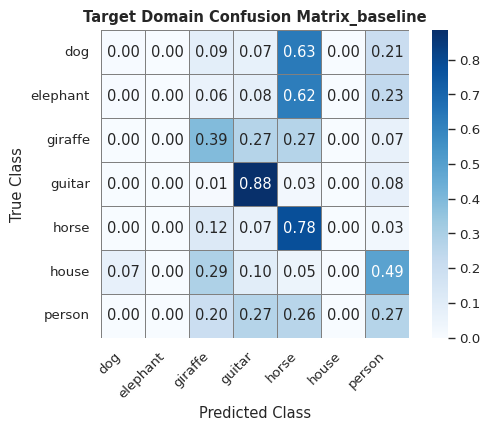

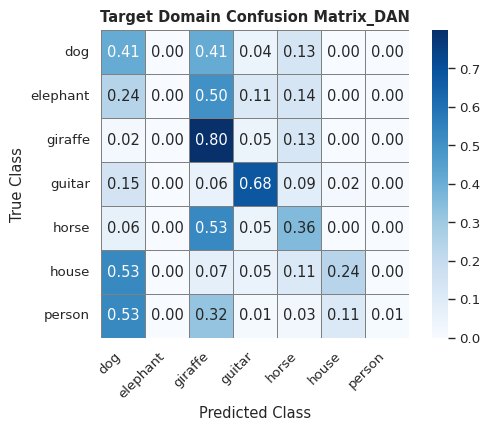

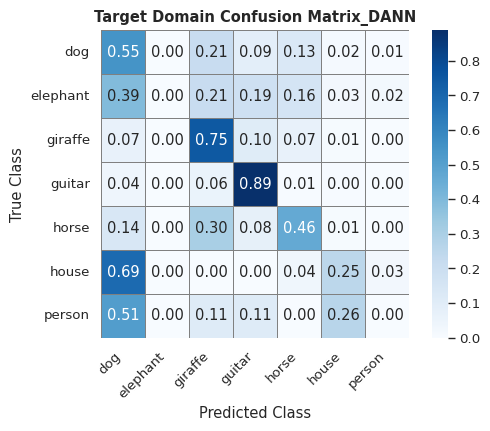

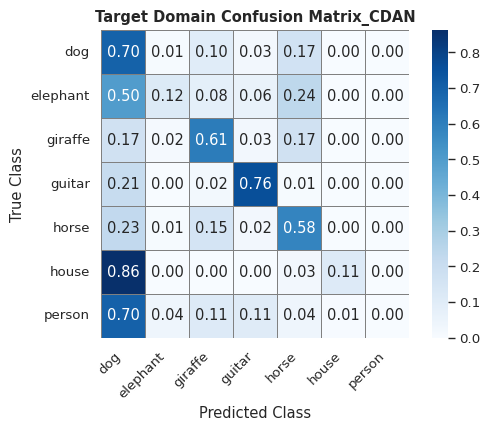

In [44]:
# confusion matrices and t-SNE for each method
for name, model in methods.items():
    plot_confusion(model, target_loader, f"{name}", classes)
    

## Self-Training on Target (Pseudo-Labeling)

In [36]:
def self_train_full(model, src_loader, tgt_loader, val_loader, rounds=5, epochs_per_round=10, lr=LR/10, conf_thresh=PSEUDO_CONF_THRESH):
    history = {"src_acc": [], "tgt_acc": [], "loss": [], "pseudo_count": []}
    ce = nn.CrossEntropyLoss()
    for round_idx in range(rounds):
        #  pseudo-labels
        model.eval()
        pseudo_images = []
        pseudo_labels = []
        pseudo_confs = []
        
        source_features = []
        source_labels = []
        with torch.no_grad():
            for imgs, labs in src_loader:
                imgs = imgs.to(DEVICE)
                _, feats = model(imgs, return_feat=True)  
                source_features.append(feats)
                source_labels.append(labs)
        source_features = torch.cat(source_features)
        source_labels = torch.cat(source_labels)
        prototypes = torch.zeros(NUM_CLASSES, source_features.size(1)).to(DEVICE)
        for c in range(NUM_CLASSES):
            mask = source_labels == c
            if mask.sum() > 0:
                prototypes[c] = source_features[mask].mean(0)

        with torch.no_grad():
            for imgs, _ in tqdm(tgt_loader, desc=f"Round {round_idx+1}: Generating pseudo-labels"):
                imgs = imgs.to(DEVICE)
                logits, feats = model(imgs, return_feat=True)  
                probs = F.softmax(logits, dim=1)
                confs, preds = probs.max(dim=1)
                for i in range(len(confs)):
                    if confs[i].item() >= conf_thresh:
                        # Prototype denoising: Check similarity to source prototype
                        _, feat = model(imgs[i].unsqueeze(0), return_feat=True)  
                        sim = F.cosine_similarity(feat[0], proto.unsqueeze(0))  
                        if sim.item() > 0.5:  # Threshold for filtering
                            pseudo_images.append(imgs[i].cpu())
                            pseudo_labels.append(preds[i].cpu()) 
                            pseudo_confs.append(float(confs[i].item()))
        print(f"Round {round_idx+1}: Collected {len(pseudo_labels)} pseudo-labeled samples with confidence >= {conf_thresh}")
        
        if len(pseudo_labels) == 0:
            print(f"Round {round_idx+1}: No pseudo-labels")
            continue
        
        #  pseudo dataset
        pseudo_imgs_tensor = torch.stack(pseudo_images)
        pseudo_labels_tensor = torch.stack(pseudo_labels)
        pseudo_dataset = TensorDataset(pseudo_imgs_tensor, pseudo_labels_tensor)
        pseudo_loader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
        
        # Combined dataset
        combined_dataset = ConcatDataset([src_loader.dataset, pseudo_dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True, collate_fn=collate)
        
        # Finetuning
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(params, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        total_iters = epochs_per_round * len(combined_loader)
        global_step = 0
        for ep in range(epochs_per_round):
            model.train()
            running_loss = 0.0
            batches = 0
            pbar = tqdm(combined_loader, desc=f"Round {round_idx+1}, Ep {ep+1}/{epochs_per_round}")
            for imgs, labs in pbar:
                lr_now = ganin_lr_schedule(global_step, total_iters, lr0=lr, power=LR_DECAY_POWER)
                for g in optimizer.param_groups:
                    g['lr'] = lr_now
                imgs, labs = imgs.to(DEVICE), labs.to(DEVICE)
                logits = model(imgs)
                loss = ce(logits, labs)
                # Add entropy regularization
                probs = F.softmax(logits, dim=1)
                entropy = -torch.mean(probs * torch.log(probs + 1e-10))
                loss += 0.1 * entropy  # Scaled entropy minimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                batches += 1
                global_step += 1
                pbar.set_postfix({"loss": running_loss/batches, "lr": lr_now})
            src_acc = evaluate(val_loader, model)
            tgt_acc = evaluate(tgt_loader, model)
            history["loss"].append(running_loss/batches)
            history["src_acc"].append(src_acc)
            history["tgt_acc"].append(tgt_acc)
            history["pseudo_count"].append(len(pseudo_labels))
            print(f"Round {round_idx+1}, Epoch {ep+1}: loss={history['loss'][-1]:.4f}, src_acc={src_acc:.4f}, tgt_acc={tgt_acc:.4f}")
        
        conf_thresh = max(0.8, conf_thresh * 0.95)  
    
    return model, history

model_self = ResNet50WithFeatures(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)

model_self.load_state_dict(torch.load("/kaggle/working/baseline_ResNet50.pth", map_location=DEVICE))
print("Loaded baseline weights into self-training model")

model_self_finetuned, history_self = self_train_full(
    model_self, source_train_loader, target_loader, source_val_loader,
    rounds=2, epochs_per_round=8, lr=LR/10, conf_thresh=PSEUDO_CONF_THRESH
)

torch.save(model_self_finetuned.state_dict(), "/kaggle/working/resnet50_selftrained.pth")

print("Saved self-trained model: /kaggle/working/resnet50_selftrained.pth")

Loaded baseline weights into self-training model


Round 1: Generating pseudo-labels: 100%|██████████| 123/123 [00:17<00:00,  6.84it/s]


Round 1: Collected 3 pseudo-labeled samples with confidence >= 0.95


Round 1, Ep 1/8: 100%|██████████| 41/41 [00:11<00:00,  3.55it/s, loss=0.0773, lr=5.5e-5] 


Round 1, Epoch 1: loss=0.0773, src_acc=0.9910, tgt_acc=0.3917


Round 1, Ep 2/8: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s, loss=0.0809, lr=3.93e-5]


Round 1, Epoch 2: loss=0.0809, src_acc=0.9880, tgt_acc=0.3986


Round 1, Ep 3/8: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s, loss=0.072, lr=3.12e-5] 


Round 1, Epoch 3: loss=0.0720, src_acc=0.9880, tgt_acc=0.3838


Round 1, Ep 4/8: 100%|██████████| 41/41 [00:11<00:00,  3.66it/s, loss=0.07, lr=2.62e-5]  


Round 1, Epoch 4: loss=0.0700, src_acc=0.9940, tgt_acc=0.4080


Round 1, Ep 5/8: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s, loss=0.0702, lr=2.27e-5]


Round 1, Epoch 5: loss=0.0702, src_acc=0.9910, tgt_acc=0.3780


Round 1, Ep 6/8: 100%|██████████| 41/41 [00:11<00:00,  3.65it/s, loss=0.0585, lr=2.01e-5]


Round 1, Epoch 6: loss=0.0585, src_acc=0.9880, tgt_acc=0.3841


Round 1, Ep 7/8: 100%|██████████| 41/41 [00:11<00:00,  3.65it/s, loss=0.0654, lr=1.82e-5]


Round 1, Epoch 7: loss=0.0654, src_acc=0.9850, tgt_acc=0.3848


Round 1, Ep 8/8: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s, loss=0.0616, lr=1.66e-5]


Round 1, Epoch 8: loss=0.0616, src_acc=0.9880, tgt_acc=0.3858


Round 2: Generating pseudo-labels: 100%|██████████| 123/123 [00:18<00:00,  6.76it/s]


Round 2: Collected 8 pseudo-labeled samples with confidence >= 0.9025


Round 2, Ep 1/8: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s, loss=0.0703, lr=5.5e-5] 


Round 2, Epoch 1: loss=0.0703, src_acc=0.9910, tgt_acc=0.3945


Round 2, Ep 2/8: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s, loss=0.0629, lr=3.93e-5]


Round 2, Epoch 2: loss=0.0629, src_acc=0.9910, tgt_acc=0.3772


Round 2, Ep 3/8: 100%|██████████| 42/42 [00:11<00:00,  3.70it/s, loss=0.0625, lr=3.12e-5]


Round 2, Epoch 3: loss=0.0625, src_acc=0.9910, tgt_acc=0.3978


Round 2, Ep 4/8: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s, loss=0.0621, lr=2.62e-5]


Round 2, Epoch 4: loss=0.0621, src_acc=0.9910, tgt_acc=0.4029


Round 2, Ep 5/8: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s, loss=0.0582, lr=2.27e-5]


Round 2, Epoch 5: loss=0.0582, src_acc=0.9910, tgt_acc=0.4024


Round 2, Ep 6/8: 100%|██████████| 42/42 [00:11<00:00,  3.57it/s, loss=0.0568, lr=2.01e-5]


Round 2, Epoch 6: loss=0.0568, src_acc=0.9880, tgt_acc=0.3825


Round 2, Ep 7/8: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s, loss=0.0569, lr=1.82e-5]


Round 2, Epoch 7: loss=0.0569, src_acc=0.9880, tgt_acc=0.3909


Round 2, Ep 8/8: 100%|██████████| 42/42 [00:11<00:00,  3.64it/s, loss=0.0528, lr=1.66e-5]


Round 2, Epoch 8: loss=0.0528, src_acc=0.9910, tgt_acc=0.3978
Saved self-trained model: /kaggle/working/resnet50_selftrained.pth


## Concept Shift

In [53]:
# utils

def plot_tsne(model, loader_src, loader_tgt, model_name, num_samples=500):
    model.eval()
    feats, domains, labels = [], [], []
    with torch.no_grad():
        for (xs, ys), (xt, yt) in zip(loader_src, loader_tgt):
            xs, xt = xs.to(device), xt.to(device)
            fs = model(xs)
            ft = model(xt)
            feats.append(fs.cpu().numpy()); domains += ["Source"]*len(fs)
            feats.append(ft.cpu().numpy()); domains += ["Target"]*len(ft)
            labels += ys.tolist() + yt.tolist()
            if len(feats)*loader_src.batch_size > num_samples:
                break
    X = np.concatenate(feats, axis=0)
    tsne = TSNE(n_components=2, init='pca', perplexity=30, learning_rate=200, random_state=42)
    X_emb = tsne.fit_transform(X)
    df = pd.DataFrame(dict(x=X_emb[:,0], y=X_emb[:,1], domain=domains, label=labels))
    
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x="x", y="y", hue="domain", style="domain", s=15, palette="tab20")
    plt.title(f"{model_name}: Source vs Target Alignment (t-SNE)", pad=10)
    plt.tight_layout()
    plt.show()

    # Plot 2: Class Clusters (t-SNE)
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x="x", y="y", hue="label", palette="tab20", legend=False, s=10)
    plt.title(f"{model_name}: Class Clusters (t-SNE)", pad=10)
    plt.tight_layout()
    plt.savefig(f"{model_name}_t-SNE.png", bbox_inches="tight")
    plt.show()


def predict_on_loader(loader, model, device=DEVICE):
    model.eval()
    all_y_true, all_y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1)
            all_y_true.extend(labels.cpu().numpy())
            all_y_pred.extend(preds.cpu().numpy())
    return np.array(all_y_true), np.array(all_y_pred)

In [45]:

rarest_three, rare_names = three_rarest_classes_from_loader(target_loader, classes)

def simulate_label_shift(dataset, reduction_ratio=0.2, rare_class_idx=None, seed=42):    
    random.seed(seed)
    np.random.seed(seed)

    targets = [y for _, y in dataset.samples]
    counter = Counter(targets)
    all_classes = list(counter.keys())
    downsample_classes = random.sample(all_classes, 3)
    
    indices = []
    for i, (_, y) in enumerate(dataset.samples):
        if rare_class_idx is not None and y == rare_class_idx:
            if random.random() < 0.1:
                indices.append(i)
        elif y in downsample_classes:
             
            if random.random() < reduction_ratio:
                indices.append(i)
        else:
            indices.append(i)
    return torch.utils.data.Subset(dataset, indices), downsample_classes


idx_to_class = {i: class_name for i, class_name in enumerate(classes)}


target_shifted, downsampled_classes = simulate_label_shift(
    target_data, 
    reduction_ratio=0.3, 
    rare_class_idx=rarest_three[0]
)

print("Downsampled classes:", [idx_to_class[i] for i in downsampled_classes])

Downsampled classes: ['house', 'dog', 'person']


In [46]:
y_true_shift, y_pred_base = predict_on_loader(DataLoader(target_shifted, batch_size=64), baseline_model)
_, y_pred_dan = predict_on_loader(DataLoader(target_shifted, batch_size=64), dan_model)
_, y_pred_dann = predict_on_loader(DataLoader(target_shifted, batch_size=64), dann_model)
_, y_pred_cdan = predict_on_loader(DataLoader(target_shifted, batch_size=64), cdan_model)

acc_shift_base = np.mean(y_true_shift == y_pred_base)
acc_shift_dan = np.mean(y_true_shift == y_pred_dan)
acc_shift_dann = np.mean(y_true_shift == y_pred_dann)
acc_shift_cdan = np.mean(y_true_shift == y_pred_cdan)

print(f"Accuracy under Label Shift:\nBaseline={acc_shift_base:.3f}, DAN={acc_shift_dan:.3f}, "
      f"DANN={acc_shift_dann:.3f}, CDAN={acc_shift_cdan:.3f}")

Accuracy under Label Shift:
Baseline=0.462, DAN=0.437, DANN=0.501, CDAN=0.515


### t-SNE Visualization

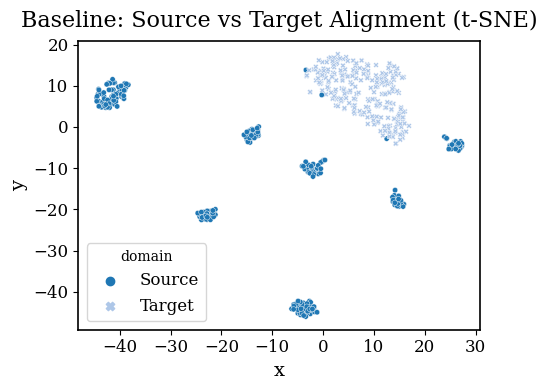

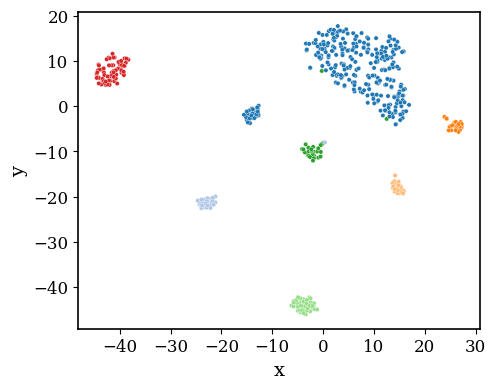

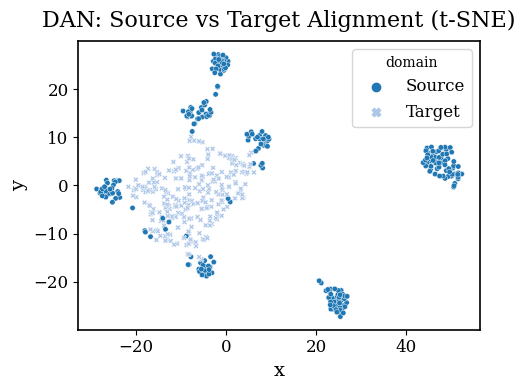

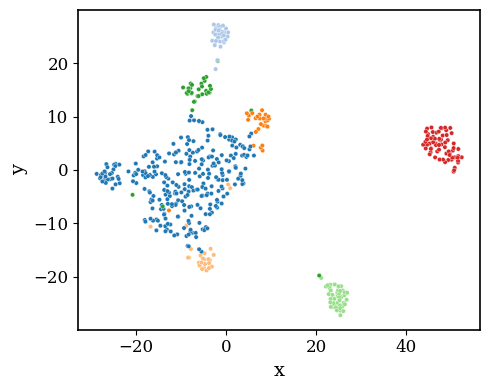

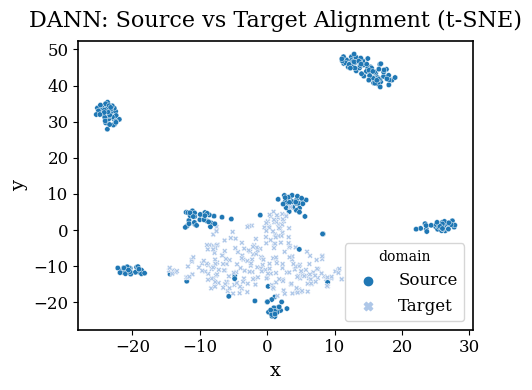

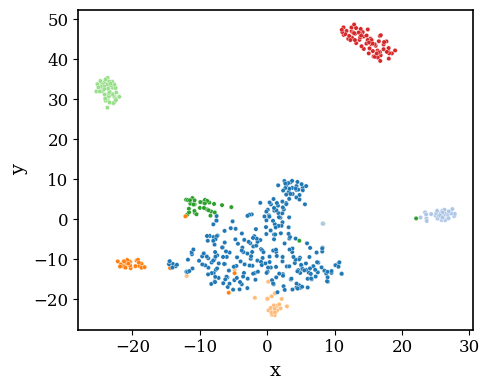

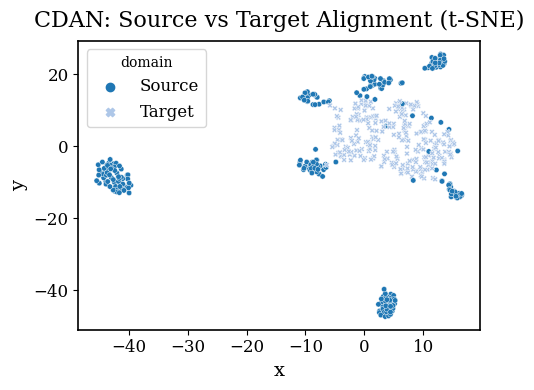

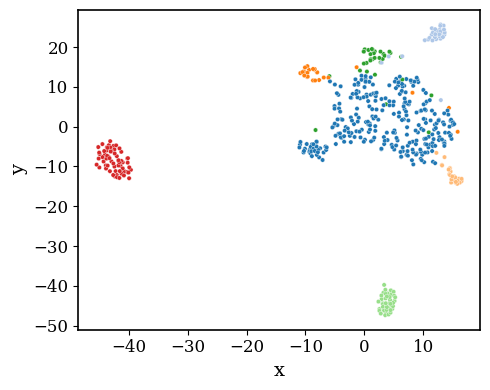

In [54]:
plot_tsne(baseline_model, source_val_loader, target_loader, "Baseline")
plot_tsne(dan_model, source_val_loader, target_loader, "DAN")
plot_tsne(dann_model, source_val_loader, target_loader, "DANN")
plot_tsne(cdan_model, source_val_loader, target_loader, "CDAN")

### confusion matrix

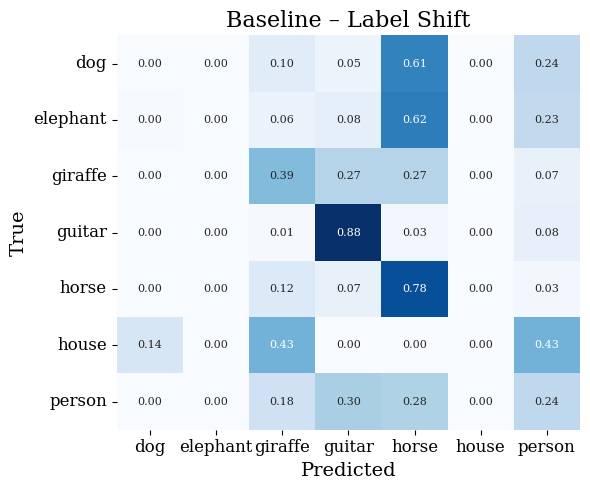

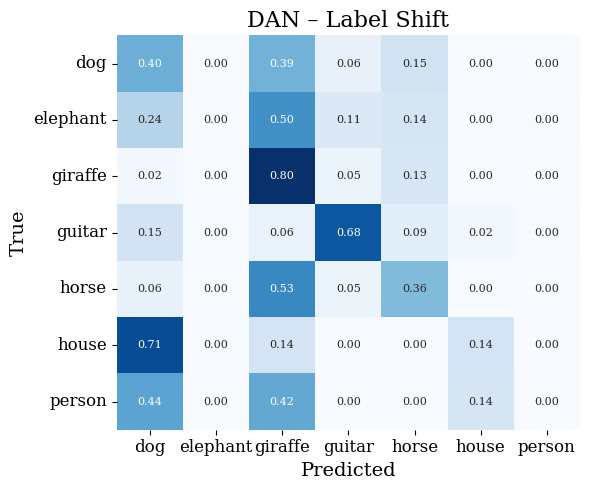

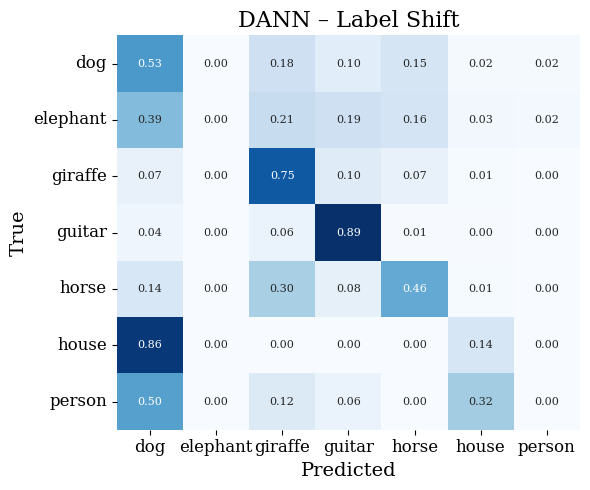

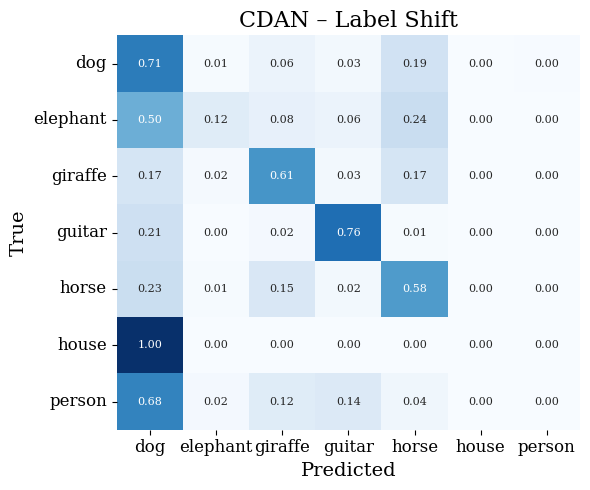

In [55]:
def plot_confusion(y_true, y_pred, title, class_names, subset_classes=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # normalized by true labels
    if subset_classes is not None:
        indices = [class_names.index(cls) for cls in subset_classes if cls in class_names]
        cm = cm[np.ix_(indices, indices)]
        labels = [class_names[i] for i in indices]
    else:
        labels = class_names

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, fmt=".2f", 
        xticklabels=labels, 
        yticklabels=labels,
        cmap="Blues", cbar=False, annot_kws={"size": 8}
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_shift, y_pred_base, "Baseline – Label Shift", [idx_to_class[i] for i in range(len(idx_to_class))])
plot_confusion(y_true_shift, y_pred_dan, "DAN – Label Shift", [idx_to_class[i] for i in range(len(idx_to_class))])
plot_confusion(y_true_shift, y_pred_dann, "DANN – Label Shift", [idx_to_class[i] for i in range(len(idx_to_class))])
plot_confusion(y_true_shift, y_pred_cdan, "CDAN – Label Shift", [idx_to_class[i] for i in range(len(idx_to_class))])

In [56]:
def get_class_distribution(dataset):

    if hasattr(dataset, "samples"):  
        labels = [y for _, y in dataset.samples]
    elif isinstance(dataset, torch.utils.data.Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        if hasattr(base_ds, "samples"):
            labels = [base_ds.samples[i][1] for i in indices]
        else:
            labels = [base_ds[i][1] for i in indices]
    else:
        labels = [y for _, y in dataset]

    counter = Counter(labels)
    total = sum(counter.values())
    return {cls: counter[cls] / total for cls in counter}


source_dist = get_class_distribution(source_data)
target_dist = get_class_distribution(target_shifted)

#  Per-class accuracies 
def per_class_accuracy(y_true, y_pred, num_classes):
    accs = []
    for c in range(num_classes):
        idxs = (y_true == c)
        if idxs.sum() > 0:
            accs.append((y_pred[idxs] == y_true[idxs]).mean())
        else:
            accs.append(np.nan)
    return np.array(accs)

num_classes = len(idx_to_class)
acc_base = per_class_accuracy(y_true_shift, y_pred_base, num_classes)
acc_dan  = per_class_accuracy(y_true_shift, y_pred_dan,  num_classes)
acc_dann = per_class_accuracy(y_true_shift, y_pred_dann, num_classes)
acc_cdan = per_class_accuracy(y_true_shift, y_pred_cdan, num_classes)


df = pd.DataFrame({
    "Class": [idx_to_class[i] for i in range(num_classes)],
    "Source_Freq": [source_dist.get(i, 0) for i in range(num_classes)],
    "Target_Freq": [target_dist.get(i, 0) for i in range(num_classes)],
    "Acc_Baseline": acc_base,
    "Acc_DAN": acc_dan,
    "Acc_DANN": acc_dann,
    "Acc_CDAN": acc_cdan
})
df["Shift"] = df["Target_Freq"] - df["Source_Freq"]
df.head()

,Class,Source_Freq,Target_Freq,Acc_Baseline,Acc_DAN,Acc_DANN,Acc_CDAN,Shift
0,dog,0.113174,0.072654,0.000000,0.399142,0.527897,0.708155,-0.040520
1,elephant,0.120958,0.230745,0.000000,0.000000,0.001351,0.117568,0.109787
2,giraffe,0.108982,0.234799,0.393094,0.799469,0.749004,0.612218,0.125817
3,guitar,0.111377,0.189585,0.884868,0.679276,0.888158,0.758224,0.078208
4,horse,0.119162,0.254443,0.778186,0.359069,0.464461,0.584559,0.135282


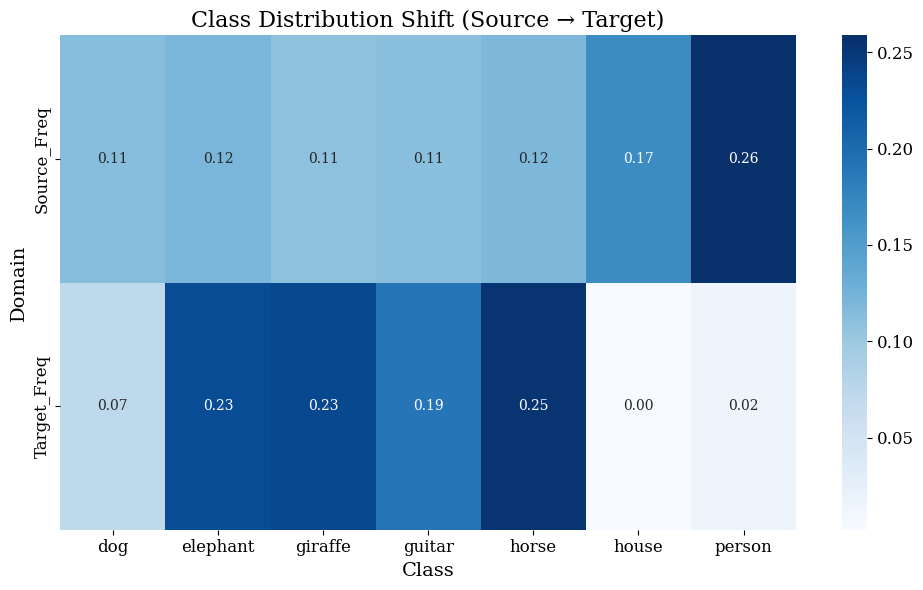

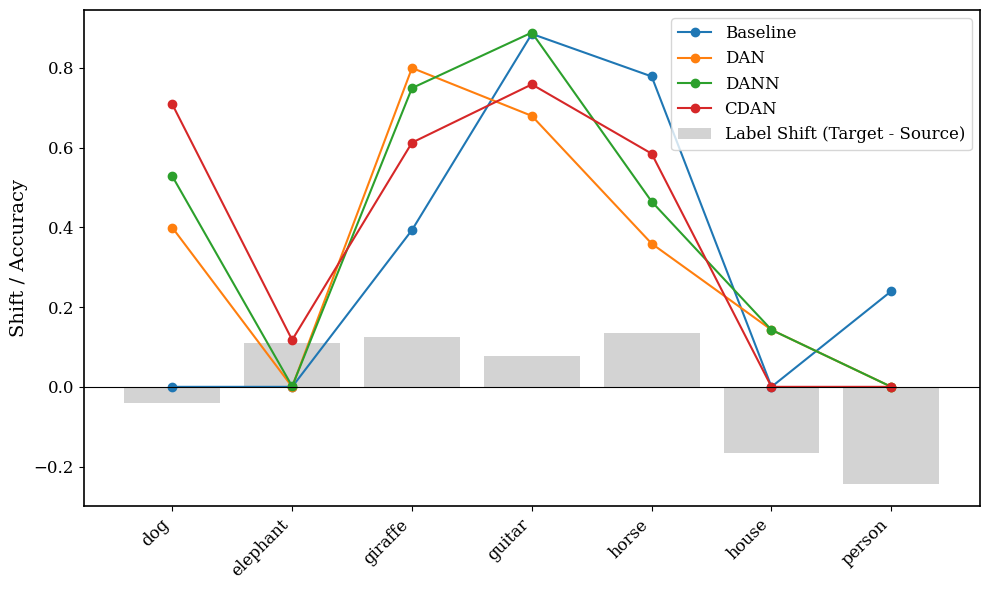

In [58]:

plt.figure(figsize=(10, 6))
sns.heatmap(
    df.set_index("Class")[["Source_Freq", "Target_Freq"]].T,
    cmap="Blues", annot=True, fmt=".2f", cbar=True
)
plt.title("Class Distribution Shift (Source → Target)")
plt.ylabel("Domain")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.bar(df["Class"], df["Shift"], color="lightgray", label="Label Shift (Target - Source)")
plt.plot(df["Class"], df["Acc_Baseline"], 'o-', label="Baseline")
plt.plot(df["Class"], df["Acc_DAN"], 'o-', label="DAN")
plt.plot(df["Class"], df["Acc_DANN"], 'o-', label="DANN")
plt.plot(df["Class"], df["Acc_CDAN"], 'o-', label="CDAN")
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Shift / Accuracy")
plt.title("Effect of Label Shift on Class-wise Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(f"{model_name}_t-SNE.png", bbox_inches="tight")
plt.show()